In [1]:
#!/usr/bin/python3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score, precision_recall_curve, confusion_matrix, roc_auc_score, roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD
from keras.utils import plot_model
from keras import backend as K
import random

random.seed()
np.random.seed()
plt.style.use('seaborn-darkgrid')

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2697abed30>,
      dtype=object)

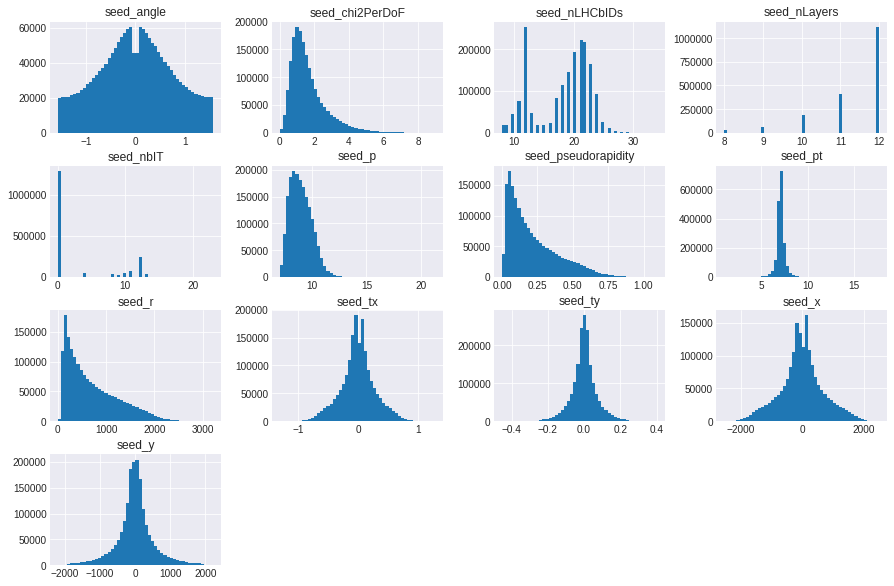

In [2]:
###########################
#getting and preparing data
###########################
data_org=pd.read_csv("rawdata.txt",sep="	", header=None)
#data_org = data_org.sample(frac=1).reset_index(drop=True)
data = pd.DataFrame(np.array(data_org)[:,1:-1])
columns=["seed_chi2PerDoF", "seed_p", "seed_pt", "seed_nLHCbIDs",
        "seed_nbIT", "seed_nLayers", "seed_x", "seed_y",
         "seed_tx", "seed_ty"]


data[data.shape[1]] = np.sqrt(data[6]*data[6]+data[7]*data[7])
columns.append('seed_r')
data[data.shape[1]] = np.arctan(data[7]/data[6])
columns.append('seed_angle')
data[data.shape[1]] = np.arctanh(data[2]/data[1])
columns.append('seed_pseudorapidity')
data[1] = np.log(data[1])
data[2] = np.log(data[2])
data.columns = columns

data.hist(bins=50, figsize=(15,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2697615da0>,
      dtype=object)

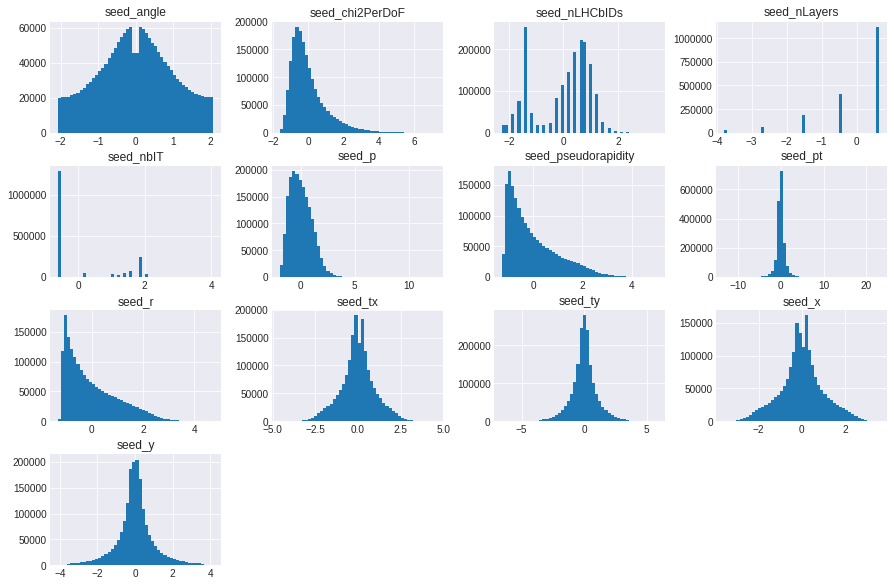

In [3]:
sc = preprocessing.StandardScaler()
data = pd.DataFrame(sc.fit_transform(data))
data.columns = columns
data.hist(bins=50, figsize=(15,10))

In [4]:
x = pd.DataFrame(np.array(data[:]))
y = pd.DataFrame(np.array(data_org)[:,0])
tab = np.array([1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])

##########################
#setting and loading model
##########################
model = Sequential()
model.add(Dense(64, activation='relu', input_dim = np.count_nonzero(tab)))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
            optimizer='adam', metrics=['accuracy'])

model.load_weights("custom_model.h5")
y_pred = model.predict(x.iloc[:, tab==1].values)

In [5]:
#############################################################
#getting ROC curve and ROC AUC
#############################################################
false_positive_rate, true_positive_rate, thresholds = roc_curve(y.values, y_pred)

print('ROC AUC ', roc_auc_score(y.values, y_pred))

ROC AUC  0.945114376902314


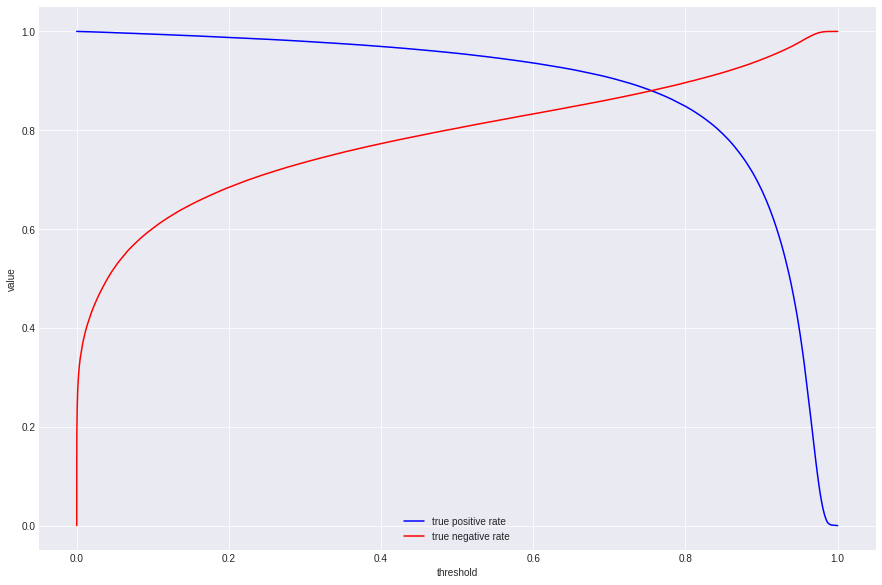

In [6]:
######################################
#ploting true positive and negative rate
######################################
plt.figure(figsize=(15, 10))
plt.plot(thresholds, true_positive_rate, 'b-')
plt.plot(thresholds, 1-false_positive_rate, 'r-')
plt.legend(['true positive rate', 'true negative rate'])
plt.xlabel('threshold')
plt.ylabel('value')

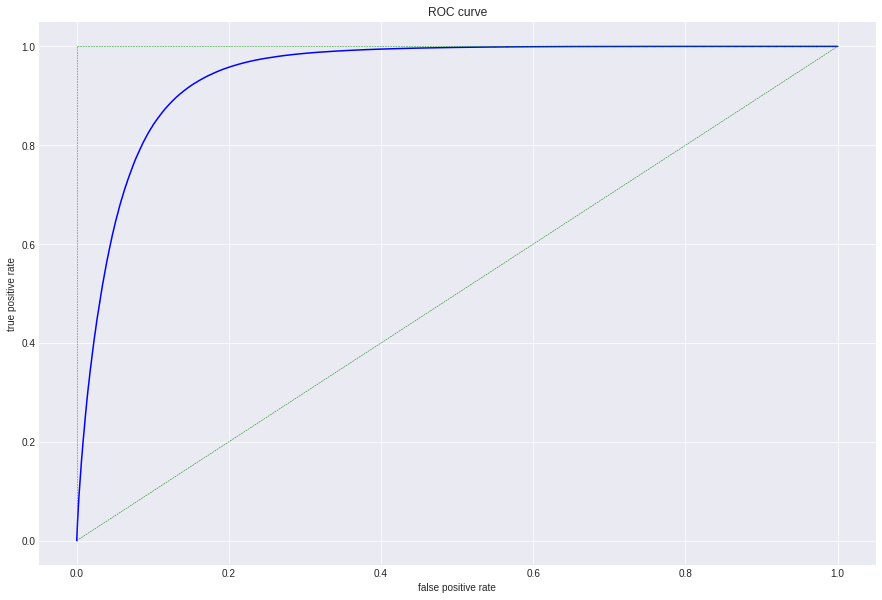

In [7]:
##################
#ploting ROC curve
##################
plt.figure(figsize=(15, 10))
plt.plot(false_positive_rate, true_positive_rate, 'b-')
plt.plot([0,1],[0,1], 'g--', linewidth=0.5)
plt.plot([0,0],[0,1], 'g--', linewidth=0.5)
plt.plot([0,1],[1,1], 'g--', linewidth=0.5)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC curve')

In [8]:
###################################################
#printing confusion matrix for couple of thresholds
###################################################
print('Confusion matrix')
for i in range(1,10):
    conf = confusion_matrix(y.values, y_pred>i/10.)
    print('Threshold ', i/10., '\n', conf.astype('float') / conf.sum(axis=1)[:, np.newaxis], '\n')

Confusion matrix
Threshold  0.1 
 [[0.60174184 0.39825816]
 [0.00553968 0.99446032]] 

Threshold  0.2 
 [[0.68460566 0.31539434]
 [0.01209922 0.98790078]] 

Threshold  0.3 
 [[0.73531644 0.26468356]
 [0.02018158 0.97981842]] 

Threshold  0.4 
 [[0.77298989 0.22701011]
 [0.03050604 0.96949396]] 

Threshold  0.5 
 [[0.8041548  0.1958452 ]
 [0.04435916 0.95564084]] 

Threshold  0.6 
 [[0.83308786 0.16691214]
 [0.06389963 0.93610037]] 

Threshold  0.7 
 [[0.86207859 0.13792141]
 [0.09353003 0.90646997]] 

Threshold  0.8 
 [[0.89637308 0.10362692]
 [0.15162677 0.84837323]] 

Threshold  0.9 
 [[0.94312201 0.05687799]
 [0.32035731 0.67964269]] 



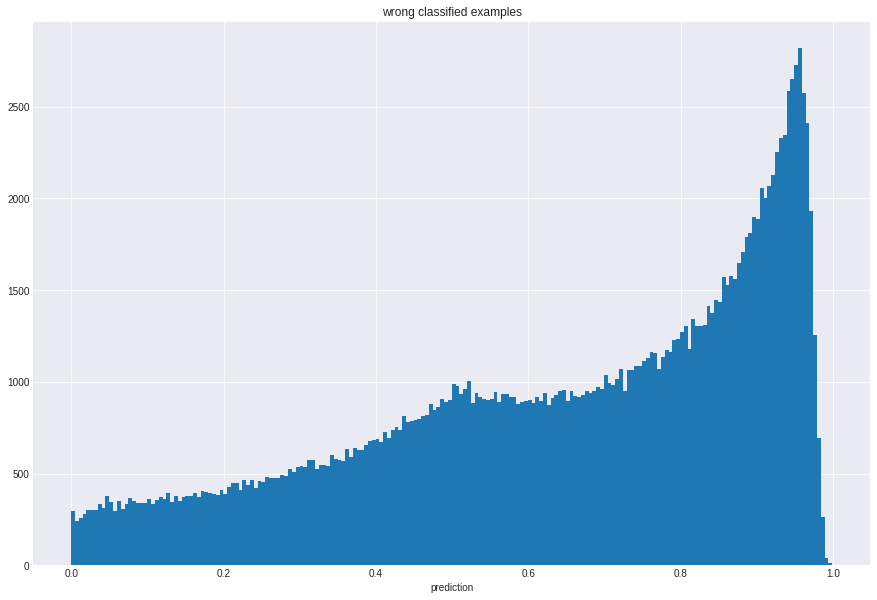

In [9]:
############################################
#ploting histogram wrong classified examples
############################################
plt.figure(figsize=(15, 10))
plt.hist(y_pred[((y_pred>=0.5).T[0] * (y.values==False).T[0]) + ((y_pred<0.5).T[0] * (y.values==True).T[0])], 200)
plt.xlabel('prediction')
plt.title('wrong classified examples')

plt.show()

K.clear_session()